In [2]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

# Adjust these if your paths are different
LOG_FILES = {
    "Gemma3": "gemma_eval_log.jsonl",
    "Qwen3": "qwen_eval_log.jsonl",
    "DeepSeek-R1": "r1_eval_log.jsonl",
}

size_pattern = re.compile(r":([\d.]+)b")  # captures the "14" in "qwen3:14b"

def load_log(path, family):
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            d = json.loads(line)

            # Skip errored runs
            if d.get("error"):
                continue

            model = d["model"]

            # Parse size like "1b", "4b", "14b", "32b" → 1.0, 4.0, 14.0, 32.0
            m = size_pattern.search(model)
            if not m:
                # e.g. qwen3:latest – skip for size-based comparison
                continue

            size_b = float(m.group(1))
            elapsed = d.get("elapsed_sec")

            if elapsed is None:
                continue

            rows.append({
                "family": family,
                "model": model,
                "size_b": size_b,
                "elapsed_sec": elapsed,
            })
    return pd.DataFrame(rows)

dfs = []
for family, path in LOG_FILES.items():
    dfs.append(load_log(path, family))

df = pd.concat(dfs, ignore_index=True)
df.head()

,family,model,size_b,elapsed_sec
0,Gemma3,gemma3:1b,1.0,6.123678
1,Gemma3,gemma3:4b,4.0,23.690001
2,Gemma3,gemma3:12b,12.0,126.293670
3,Gemma3,gemma3:27b,27.0,326.009366
4,Qwen3,qwen3:0.6b,0.6,11.241300


In [5]:
df

,family,model,size_b,elapsed_sec
0,Gemma3,gemma3:1b,1.0,6.123678
1,Gemma3,gemma3:4b,4.0,23.690001
2,Gemma3,gemma3:12b,12.0,126.293670
3,Gemma3,gemma3:27b,27.0,326.009366
4,Qwen3,qwen3:0.6b,0.6,11.241300
5,Qwen3,qwen3:1.7b,1.7,23.907061
6,Qwen3,qwen3:14b,14.0,19.322945
7,Qwen3,qwen3:32b,32.0,268.948101
8,DeepSeek-R1,deepseek-r1:7b,7.0,50.800211
9,DeepSeek-R1,deepseek-r1:8b,8.0,84.336688


In [3]:
summary = (
    df.groupby(["family", "size_b"])["elapsed_sec"]
      .agg(["mean", "std", "count"])
      .reset_index()
      .sort_values(["size_b", "family"])
)

summary


,family,size_b,mean,std,count
8,Qwen3,0.6,11.241300,NaN,1
4,Gemma3,1.0,6.123678,NaN,1
9,Qwen3,1.7,23.907061,NaN,1
5,Gemma3,4.0,23.690001,NaN,1
0,DeepSeek-R1,7.0,50.800211,NaN,1
1,DeepSeek-R1,8.0,84.336688,NaN,1
6,Gemma3,12.0,126.293670,NaN,1
2,DeepSeek-R1,14.0,147.141991,NaN,1
10,Qwen3,14.0,19.322945,NaN,1
7,Gemma3,27.0,326.009366,NaN,1


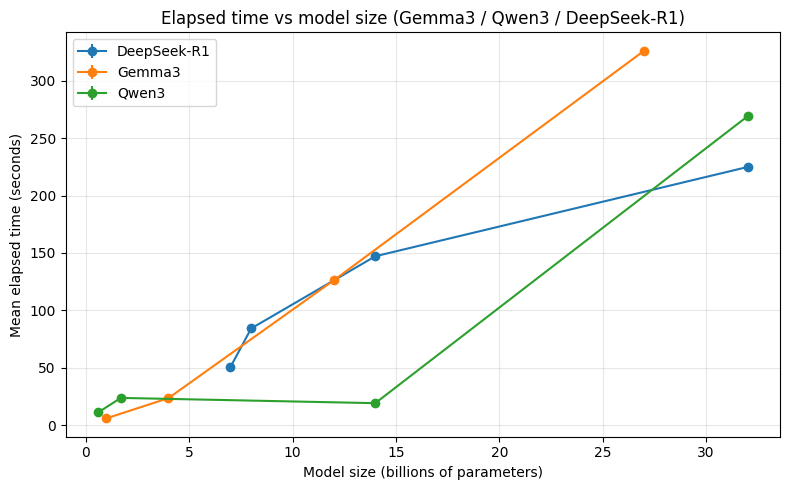

In [4]:
plt.figure(figsize=(8, 5))

for family, grp in summary.groupby("family"):
    grp = grp.sort_values("size_b")
    plt.errorbar(
        grp["size_b"],
        grp["mean"],
        yerr=grp["std"],
        marker="o",
        label=family,
    )

plt.xlabel("Model size (billions of parameters)")
plt.ylabel("Mean elapsed time (seconds)")
plt.title("Elapsed time vs model size (Gemma3 / Qwen3 / DeepSeek-R1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import json
import re
import pandas as pd

# 👉 Adjust these paths to wherever your files are
LOG_FILES = {
    # "Gemma3": "gemma_eval_log.jsonl",
    # "Qwen3": "qwen_eval_log.jsonl",
    # "DeepSeek-R1": "r1_eval_log.jsonl",
    'Cloud': "cloud_eval_log.jsonl"
}

def load_jsonl_with_family(path, family):
    rows = []
    with open(path, "r") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue

            # ---- robust JSON parse ----
            try:
                d = json.loads(line)
            except json.JSONDecodeError:
                print(f"[WARN] Skipping bad JSON in {path} (line {line_no})")
                continue

            # ---- safely get fields, skip if missing ----
            model = d.get("model")
            ann = d.get("annotation") or {}
            table_summary = ann.get("table_summary")

            # If model or summary missing (e.g. R1 1.5B), just skip
            if not model or not table_summary:
                # Uncomment if you want to see what’s skipped:
                # print(f"[INFO] Skipping {path} line {line_no} (missing model/table_summary)")
                continue

            rows.append(
                {
                    "family": family,
                    "model": model,
                    "table_summary": table_summary,
                }
            )
    return rows

# ---- load all families ----
all_rows = []
for family, path in LOG_FILES.items():
    all_rows.extend(load_jsonl_with_family(path, family))

df = pd.DataFrame(all_rows)

# Optional: parse model size like ":1.5b", ":7b", ":14b" → 1.5, 7.0, 14.0
size_pattern = re.compile(r":([\d.]+)b", re.IGNORECASE)

def get_size_b(model: str):
    m = size_pattern.search(model)
    return float(m.group(1)) if m else None

df["size_b"] = df["model"].apply(get_size_b)

pd.set_option("display.max_colwidth", None)
df.head()


,family,model,table_summary,size_b
0,Cloud,glm-4.6:cloud,"This table presents Apple Inc.'s consolidated statements of operations for the fiscal years ending September 27, 2025, September 28, 2024, and September 30, 2023, showing revenue, costs, margins, expenses, income, and earnings per share.",NaN
1,Cloud,kimi-k2:1t-cloud,"Apple Inc.'s consolidated statements of operations for the fiscal years ended September 27, 2025, September 28, 2024, and September 30, 2023, showing net sales, costs, expenses, operating and net income, earnings per share, and share counts.",NaN
2,Cloud,minimax-m2:cloud,"Consolidated statements of operations for Apple Inc. for the years ended September 27, 2025, September 28, 2024, and September 30, 2023, showing revenue, costs, expenses, income, taxes, net income, earnings per share, and shares used in computing EPS.",NaN
3,Cloud,deepseek-v3.1:671b-cloud,"This table presents the Consolidated Statements of Operations for Apple Inc. for the fiscal years ended September 27, 2025, September 28, 2024, and September 30, 2023, showing the breakdown of net sales, costs, expenses, and resulting profitability metrics.",671.0
4,Cloud,gpt-oss:120b-cloud,"The table presents Apple’s consolidated statements of operations for fiscal years ended September 27, 2025, September 28, 2024, and September 30, 2023, detailing net sales, cost of sales, gross margin, operating expenses, operating income, other income/expense, income before taxes, provision for taxes, net income, earnings per share, and the share counts used in EPS calculations.",120.0


In [10]:
import json
import pandas as pd

log_path = "cloud_eval_log.jsonl"  # adjust if needed

records = []

with open(log_path, "r") as f:
    for line_no, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue

        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            print(f"[WARN] bad JSON at line {line_no}, skipping")
            continue

        model = obj.get("model")
        ann = obj.get("annotation") or {}

        # some models (e.g. kimi-k2-thinking) might have no annotation / row_summaries
        for rs in ann.get("row_summaries", []):
            records.append(
                {
                    "model": model,
                    "row_index": rs.get("row_index"),
                    "row_label": rs.get("row_label"),
                    "description": rs.get("description"),
                }
            )

df_rows = pd.DataFrame(records)
df_rows = df_rows.sort_values(["row_index", "model"]).reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
df_rows.head()


,model,row_index,row_label,description
0,deepseek-v3.1:671b-cloud,0,Products,This row shows the net sales from Products for each of the three fiscal years.
1,glm-4.6:cloud,0,Net sales:,This row introduces the net sales section of the statement.
2,gpt-oss:120b-cloud,0,Net sales:,Header row introducing the net sales categories.
3,gpt-oss:20b-cloud,0,Net sales:,"Net sales: Products row shows product sales revenue for the year ended September 27, 2025."
4,kimi-k2:1t-cloud,0,Net sales: Products,Revenue from product sales for each fiscal year.


In [11]:
df_rows

,model,row_index,row_label,description
0,deepseek-v3.1:671b-cloud,0,Products,This row shows the net sales from Products for each of the three fiscal years.
1,glm-4.6:cloud,0,Net sales:,This row introduces the net sales section of the statement.
2,gpt-oss:120b-cloud,0,Net sales:,Header row introducing the net sales categories.
3,gpt-oss:20b-cloud,0,Net sales:,"Net sales: Products row shows product sales revenue for the year ended September 27, 2025."
4,kimi-k2:1t-cloud,0,Net sales: Products,Revenue from product sales for each fiscal year.
...,...,...,...,...
124,gpt-oss:120b-cloud,22,Basic,Number of basic shares used in the basic earnings per share calculation.
125,gpt-oss:20b-cloud,22,Basic,"Basic row shows the number of shares used to compute basic earnings per share for the year ended September 27, 2025."
126,glm-4.6:cloud,23,Diluted,This row shows the number of diluted shares used in computing earnings per share for each fiscal year.
127,gpt-oss:120b-cloud,23,Diluted,Number of diluted shares used in the diluted earnings per share calculation.


In [12]:
"""
Compare row summaries across cloud models from evaluation logs.

This script loads JSONL evaluation data and provides multiple comparison methods:
1. Side-by-side comparison of descriptions for each row
2. Summary statistics (coverage, validity, errors)
3. Semantic similarity analysis (optional, requires sentence-transformers)
4. Export comparisons to CSV/Excel for manual review
"""

import json
import pandas as pd
from pathlib import Path
from collections import defaultdict
from typing import Optional


def load_eval_data(filepath: str) -> list[dict]:
    """Load JSONL evaluation data."""
    records = []
    with open(filepath, 'r') as f:
        for line in f:
            records.append(json.loads(line.strip()))
    return records


def extract_row_summaries(records: list[dict]) -> dict[str, dict]:
    """
    Extract row summaries indexed by model.
    Returns: {model_name: {row_index: {row_label, description}}}
    """
    model_summaries = {}
    for rec in records:
        model = rec['model']
        annotation = rec.get('annotation')
        
        if annotation and annotation.get('row_summaries'):
            summaries = {}
            for row in annotation['row_summaries']:
                summaries[row['row_index']] = {
                    'row_label': row['row_label'],
                    'description': row['description']
                }
            model_summaries[model] = {
                'table_summary': annotation.get('table_summary', ''),
                'row_summaries': summaries
            }
        else:
            model_summaries[model] = {
                'table_summary': None,
                'row_summaries': {},
                'error': rec.get('error')
            }
    
    return model_summaries


def create_comparison_dataframe(model_summaries: dict) -> pd.DataFrame:
    """
    Create a DataFrame with side-by-side row descriptions from each model.
    """
    # Collect all unique row indices and labels
    all_rows = {}
    for model, data in model_summaries.items():
        for idx, info in data.get('row_summaries', {}).items():
            if idx not in all_rows:
                all_rows[idx] = info['row_label']
    
    # Build comparison rows
    comparison_data = []
    for row_idx in sorted(all_rows.keys()):
        row_data = {
            'row_index': row_idx,
            'row_label': all_rows[row_idx]
        }
        for model in model_summaries.keys():
            summaries = model_summaries[model].get('row_summaries', {})
            if row_idx in summaries:
                row_data[f'{model}_desc'] = summaries[row_idx]['description']
            else:
                row_data[f'{model}_desc'] = None
        comparison_data.append(row_data)
    
    return pd.DataFrame(comparison_data)


def create_metrics_summary(records: list[dict]) -> pd.DataFrame:
    """
    Create a summary DataFrame of evaluation metrics per model.
    """
    metrics = []
    for rec in records:
        metrics.append({
            'model': rec['model'],
            'table_title': rec['table_title'],
            'elapsed_sec': rec['elapsed_sec'],
            'json_valid': rec['json_valid'],
            'error': rec.get('error'),
            'n_row_summaries': rec['n_row_summaries'],
            'row_index_valid_fraction': rec['row_index_valid_fraction'],
            'row_index_coverage_fraction': rec['row_index_coverage_fraction'],
            'rows_with_non_year_number_fraction': rec['rows_with_non_year_number_fraction'],
            'has_any_non_year_numbers': rec['has_any_non_year_numbers'],
            'table_summary_has_non_year_numbers': rec['table_summary_has_non_year_numbers']
        })
    return pd.DataFrame(metrics)


def compute_description_lengths(model_summaries: dict) -> pd.DataFrame:
    """
    Analyze description lengths across models.
    """
    length_data = []
    for model, data in model_summaries.items():
        for idx, info in data.get('row_summaries', {}).items():
            length_data.append({
                'model': model,
                'row_index': idx,
                'row_label': info['row_label'],
                'desc_length': len(info['description']),
                'word_count': len(info['description'].split())
            })
    return pd.DataFrame(length_data)


def print_side_by_side(comparison_df: pd.DataFrame, models: list[str], max_width: int = 50):
    """
    Print a formatted side-by-side comparison of descriptions.
    """
    def truncate(text, width):
        if text is None:
            return "N/A".ljust(width)
        text = str(text)
        if len(text) > width:
            return text[:width-3] + "..."
        return text.ljust(width)
    
    # Header
    header = "Row".ljust(30)
    for model in models:
        short_name = model.split(':')[0][:12]
        header += short_name.ljust(max_width + 2)
    print(header)
    print("=" * len(header))
    
    # Rows
    for _, row in comparison_df.iterrows():
        line = f"{row['row_index']:2d}. {row['row_label'][:25]}".ljust(30)
        for model in models:
            col = f"{model}_desc"
            line += truncate(row.get(col), max_width) + "  "
        print(line)


def compare_table_summaries(model_summaries: dict):
    """
    Print table-level summaries from each model.
    """
    print("\n" + "="*80)
    print("TABLE SUMMARIES BY MODEL")
    print("="*80)
    
    for model, data in model_summaries.items():
        print(f"\n[{model}]")
        if data.get('table_summary'):
            print(f"  {data['table_summary']}")
        elif data.get('error'):
            print(f"  ERROR: {data['error']}")
        else:
            print("  (No summary available)")


def export_to_excel(comparison_df: pd.DataFrame, metrics_df: pd.DataFrame, 
                    lengths_df: pd.DataFrame, output_path: str):
    """
    Export all comparison data to an Excel file with multiple sheets.
    """
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        comparison_df.to_excel(writer, sheet_name='Row Comparisons', index=False)
        metrics_df.to_excel(writer, sheet_name='Model Metrics', index=False)
        
        # Pivot length stats
        if not lengths_df.empty:
            length_stats = lengths_df.groupby('model').agg({
                'desc_length': ['mean', 'std', 'min', 'max'],
                'word_count': ['mean', 'std', 'min', 'max']
            }).round(2)
            length_stats.to_excel(writer, sheet_name='Description Stats')
    
    print(f"\nExported comparison to: {output_path}")


# Main execution
# if __name__ == "__main__":
    # Load data
filepath = "cloud_eval_log.jsonl"
records = load_eval_data(filepath)

print(f"Loaded {len(records)} evaluation records")
print(f"Models: {[r['model'] for r in records]}")

# Extract summaries
model_summaries = extract_row_summaries(records)

# Create comparison DataFrame
comparison_df = create_comparison_dataframe(model_summaries)

# Create metrics summary
metrics_df = create_metrics_summary(records)

# Compute description lengths
lengths_df = compute_description_lengths(model_summaries)

# Display metrics summary
print("\n" + "="*80)
print("MODEL METRICS SUMMARY")
print("="*80)
print(metrics_df[['model', 'elapsed_sec', 'json_valid', 'n_row_summaries', 
                  'row_index_coverage_fraction', 'rows_with_non_year_number_fraction']].to_string(index=False))

# Display table summaries
compare_table_summaries(model_summaries)

# Display description length statistics
print("\n" + "="*80)
print("DESCRIPTION LENGTH STATISTICS (by model)")
print("="*80)
if not lengths_df.empty:
    stats = lengths_df.groupby('model')['word_count'].agg(['mean', 'std', 'min', 'max'])
    print(stats.round(2).to_string())

# Side-by-side comparison (first few rows)
models_with_data = [m for m, d in model_summaries.items() if d.get('row_summaries')]
print("\n" + "="*80)
print("SIDE-BY-SIDE ROW DESCRIPTIONS (truncated)")
print("="*80)
print_side_by_side(comparison_df.head(10), models_with_data, max_width=40)

# Export to Excel
output_path = "/mnt/user-data/outputs/model_comparison.xlsx"
# export_to_excel(comparison_df, metrics_df, lengths_df, output_path)

# Also save the full comparison as CSV
csv_path = "/mnt/user-data/outputs/row_comparison.csv"
# comparison_df.to_csv(csv_path, index=False)
print(f"Saved CSV comparison to: {csv_path}")

Loaded 7 evaluation records
Models: ['glm-4.6:cloud', 'kimi-k2-thinking:cloud', 'kimi-k2:1t-cloud', 'minimax-m2:cloud', 'deepseek-v3.1:671b-cloud', 'gpt-oss:120b-cloud', 'gpt-oss:20b-cloud']

MODEL METRICS SUMMARY
                   model  elapsed_sec  json_valid  n_row_summaries  row_index_coverage_fraction  rows_with_non_year_number_fraction
           glm-4.6:cloud    14.956853        True               24                     0.923077                                 0.0
  kimi-k2-thinking:cloud    64.231987       False                0                     0.000000                                 0.0
        kimi-k2:1t-cloud    19.207029        True               19                     0.730769                                 0.0
        minimax-m2:cloud    15.350703        True               19                     0.730769                                 0.0
deepseek-v3.1:671b-cloud    14.425715        True               19                     0.730769                               